In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-05-16 17:44:24.517328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 17:44:25.750373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-16 17:44:25.750517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-05-16 17:44:25.750536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#metrics= [sigma_loss,sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma]
metrics= [sigma_loss,sigma_batch_loss,mse_tau,mse_sigma,sigma_f_loss]
home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_16_5_23/"
checkpoint_dir = '/home/amorelli/r_estimate/B_maps_white_noise/results_14_5_23/checkpoints' 
r_like=[0.0,0.001,0.005,0.007,0.01] #these are the r_test of the maps on which i test the NN 
sigma_exact=[0.000225922*2, 0.000398311, 0.001017338,0.001142098,0.0015324*2] #these are the sigma computed for the 
#r_test using the likelihood approach
load_dir='/home/amorelli/r_estimate/B_maps_white_noise/' 
to_load=['test_data_r0000_t006_150.npz','test_data_r0001_t006_15.npz','test_data_r0005_t006_241.npz',
         'test_data_r0007_t006_241.npz','test_data_r0010_t006_24.npz'] #these are the test maps
loss_kind="sigma" #var
loss_training=sigma_batch_loss 
test_model_folder="test_model"

In [3]:
try:
    hyperparameters=pd.read_csv(home_dir+"output.txt",delim_whitespace=True, index_col=None) #i try to read the 
    #file with the hyperparameters used in the training
except:
    print("no file to read") 
    dataframe={}
    dataframe["no data"]=["-"]
    hyperparameters=pd.DataFrame(dataframe)#if there is no file to read (because i analyse an old model) i create an 
    #empty dataframe
finally:
    None #i use this so that the program continue after the try,except
print(hyperparameters)

      name             loss  noise  p_stopping  p_reduce  f_reduce  \
0  16_5_23  new_sigma_batch      4          20         5       0.5   

              stop-reduce      lr  batch_size  n_layers  nodes_layers comments  
0  val_mse_batch-val_loss  0.0003          32      True            48           


In [4]:
files=[]
for name in to_load: 
    files.append(np.load(load_dir+name) )
x_test=[]
y_test=[]
for i,f in enumerate(files):#i take the maps and the corresponding r_test for each input file
    x_test.append(f["x_test"])
    y=np.zeros(len(x_test[i]))+f["y_test"] #y_test is a single number in the file -> i need to transform it in an array
    #of the same length of x_test
    y_test.append(y.reshape(y.shape[0],1))

In [5]:
n_layer_0=48
n_layer_1=256
n_layer_2=16
nside=16
drop=0.2
one_layer=True
shape = (hp.nside2npix(nside), 2)
inputs = tf.keras.layers.Input(shape)
# nside 16 -> 8
x=inputs
for k in range(4):
    x = nnhealpix.layers.ConvNeighbours(nside//2**k, filters=32, kernel_size=9)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = nnhealpix.layers.Dgrade(nside//2**k, nside//2**(k+1))(x) # i use 4 convolutional layers, for each layer i decrease the number of pixels by 1/2
# dropout
x = tf.keras.layers.Dropout(drop)(x)
x = tf.keras.layers.Flatten()(x)
if one_layer==True:# depending on the state os one_layer i create a NN with one layer or with two layers
    x = tf.keras.layers.Dense(n_layer_0)(x)
    x = tf.keras.layers.Activation('relu')(x)
    out = tf.keras.layers.Dense(2)(x)
else:
    x = tf.keras.layers.Dense(n_layer_1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(drop)(x)
    x = tf.keras.layers.Dense(n_layer_2)(x)
    x = tf.keras.layers.Activation('relu')(x)
    out = tf.keras.layers.Dense(2)(x)
tf.keras.backend.clear_session()
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

2023-05-16 17:44:34.086603: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-16 17:44:34.086953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-05-16 17:44:34.088472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
files=os.listdir(checkpoint_dir)
files.sort()
checkpoint_path=files[33]
model.load_weights(checkpoint_dir+'/'+ checkpoint_path)

In [7]:
results=[]
predictions=[]
for x,y in zip(x_test,y_test): #i compute the predictions of the model for each test_set and save them in a dict
    results.append(model.evaluate(x,y,verbose=2) )
    predictions.append(model.predict(x))
npz_dict={}
for i,p in enumerate(predictions):
    npz_dict[f"sigma_{r_like[i]}"]=p[:,1]
np.savez(home_dir+"sigma_out", **npz_dict)

2023-05-16 17:44:34.922020: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 - 8s - loss: 1.2201e-06 - sigma_loss: 2.8627e-06 - sigma_batch_loss: 1.2191e-06 - mse_tau: 1.1091e-06 - mse_sigma: 1.7536e-06 - sigma_f_loss: 175.3578 - 8s/epoch - 24ms/step


2023-05-16 17:44:43.239026: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 [==============================] - 7s 20ms/step


2023-05-16 17:44:50.803118: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 - 6s - loss: 5.4621e-06 - sigma_loss: 1.1167e-05 - sigma_batch_loss: 5.4572e-06 - mse_tau: 5.2129e-06 - mse_sigma: 5.9541e-06 - sigma_f_loss: 595.4066 - 6s/epoch - 20ms/step
  1/313 [..............................] - ETA: 23s

2023-05-16 17:44:57.874850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 [==============================] - 6s 20ms/step


2023-05-16 17:45:05.326087: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 - 6s - loss: 4.5807e-05 - sigma_loss: 7.9037e-05 - sigma_batch_loss: 4.5779e-05 - mse_tau: 4.4396e-05 - mse_sigma: 3.4641e-05 - sigma_f_loss: 3464.0515 - 6s/epoch - 20ms/step
313/313 [==============================] - 6s 19ms/step
313/313 - 6s - loss: 3.5933e-05 - sigma_loss: 6.8031e-05 - sigma_batch_loss: 3.5917e-05 - mse_tau: 3.5191e-05 - mse_sigma: 3.2840e-05 - sigma_f_loss: 3284.0005 - 6s/epoch - 19ms/step
313/313 [==============================] - 6s 20ms/step
313/313 - 6s - loss: 5.3520e-05 - sigma_loss: 7.6847e-05 - sigma_batch_loss: 5.3496e-05 - mse_tau: 4.9747e-05 - mse_sigma: 2.7101e-05 - sigma_f_loss: 2710.0503 - 6s/epoch - 19ms/step
313/313 [==============================] - 6s 20ms/step


tau_pred=predictions[:,0]
sigma_pred=np.abs(predictions[:,1])#*predictions[:,1]
tau_est=np.mean(tau_pred)
sigma_tau=np.std(tau_pred)**2
#sigma_tau=np.sum((tau_pred-0.06)**2)/10000
sigma_est=np.mean(sigma_pred)
counts_tau, bins_tau = np.histogram(tau_pred)
counts_sigma, bins_sigma = np.histogram(sigma_pred)

In [8]:
if loss_kind=="sigma": #if the output of the NN is directly the std i do some operations and print some values, if
    #it gives the variance i do in a different way
    r_pred=[]
    sigma_pred=[]
    r_est=[]
    sigma_r=[]
    sigma_est=[]
    sigma_sigma=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_sigma=[]
    median_r=[]
    median_sigma=[]
    for i,p in enumerate(predictions): #i compute mean, std, etc for each set of predictions and save them in the corresponding
        #dictionaries (see above)
        r_pred.append(p[:,0])
        sigma_pred.append(p[:,1])
        r_est.append(np.mean(r_pred[i]))
        sigma_r.append(np.std(r_pred[i]))
        sigma_est.append(np.mean(sigma_pred[i]))
        sigma_sigma.append(np.std(sigma_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_sigma.append(np.sum(((sigma_pred[i]-sigma_est[i])/sigma_sigma[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_sigma.append(np.median(sigma_pred[i]))
    #r_test=np.asarray([int(x*100)/100 for x in r_est])
    #sigma_like=np.empty_like(r_test,dtype=float)
    #for r in r_test:
        #i=r_like.index(r)
        #sigma_like[i]=sigma_exact[i]
    d={}# i create a dictionary that stores the value of the following keywords for each test_set
    d["r_test"]=r_like
    d["r_est"]=r_est
    d["dr"]=np.abs(np.asarray(r_like)-np.asarray(r_est))/r_est
    d["median_r-r_est"]=np.asarray(median_r)-np.asarray(r_est)
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    d["sigma_r"]=sigma_r
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_est))/sigma_est
    d["dlike"]=np.abs(np.asarray(sigma_r)-np.asarray(sigma_exact))/sigma_r
    d["sigma_sigma"]=sigma_sigma
    d["median_sigma-sigma_est"]=np.asarray(median_sigma)-np.asarray(sigma_est)
    d["skeweness_sigma"]=skeweness_sigma

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times. I do this because i want to join the hyperpar. dataframe
    #with the r_data dataframe and the hyperparam. dataframe only has one row
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))
    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1) # i join the two dataframes so that i can copy-paste all the info for one model directly
    #in excel

    print(out_df)
    out_df.to_csv(home_dir+'results.txt', index=False, sep=';')

      name             loss noise p_stopping p_reduce f_reduce  \
0  16_5_23  new_sigma_batch     4         20        5      0.5   
1  16_5_23  new_sigma_batch     4         20        5      0.5   
2  16_5_23  new_sigma_batch     4         20        5      0.5   
3  16_5_23  new_sigma_batch     4         20        5      0.5   
4  16_5_23  new_sigma_batch     4         20        5      0.5   

              stop-reduce      lr batch_size n_layers  ... median_r-r_est  \
0  val_mse_batch-val_loss  0.0003         32     True  ...      -0.000008   
1  val_mse_batch-val_loss  0.0003         32     True  ...      -0.000043   
2  val_mse_batch-val_loss  0.0003         32     True  ...      -0.000036   
3  val_mse_batch-val_loss  0.0003         32     True  ...       0.000088   
4  val_mse_batch-val_loss  0.0003         32     True  ...       0.000181   

      mae_r  skeweness_r   sigma_r  sigma_est    dsigma     dlike  \
0  0.000106     0.351146  0.000135   0.000232  0.421034  2.358430   
1 

In [9]:
if loss_kind=="sigma": 
    for i in range(len(r_pred)):
        print("on_test_set r =",r_like[i])
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("sigma_r:",sigma_r[i], " This is the std of the $r_i^{NN}$ array (std of the prediction).")
        print("sigma_r_est:", sigma_est[i], "  This is the average of the $\sigma_{i}$ estimated by the network on the test set.")
        print("\n")

on_test_set r = 0.0
r_est: 0.00012889158   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.00013454026  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.00023238022   This is the average of the $\sigma_{i}$ estimated by the network on the test set.


on_test_set r = 0.001
r_est: 0.001088422   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0003941381  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.00042677144   This is the average of the $\sigma_{i}$ estimated by the network on the test set.


on_test_set r = 0.005
r_est: 0.005283512   This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.
sigma_r: 0.0011442113  This is the std of the $r_i^{NN}$ array (std of the prediction).
sigma_r_est: 0.0010396655   This is the average of the $\sigma_{i}$ estimated by the network on the test set.


on_test_set r = 0.007


n_of_bins: 75
n_of_bins: 52
n_of_bins: 46
n_of_bins: 50
n_of_bins: 86


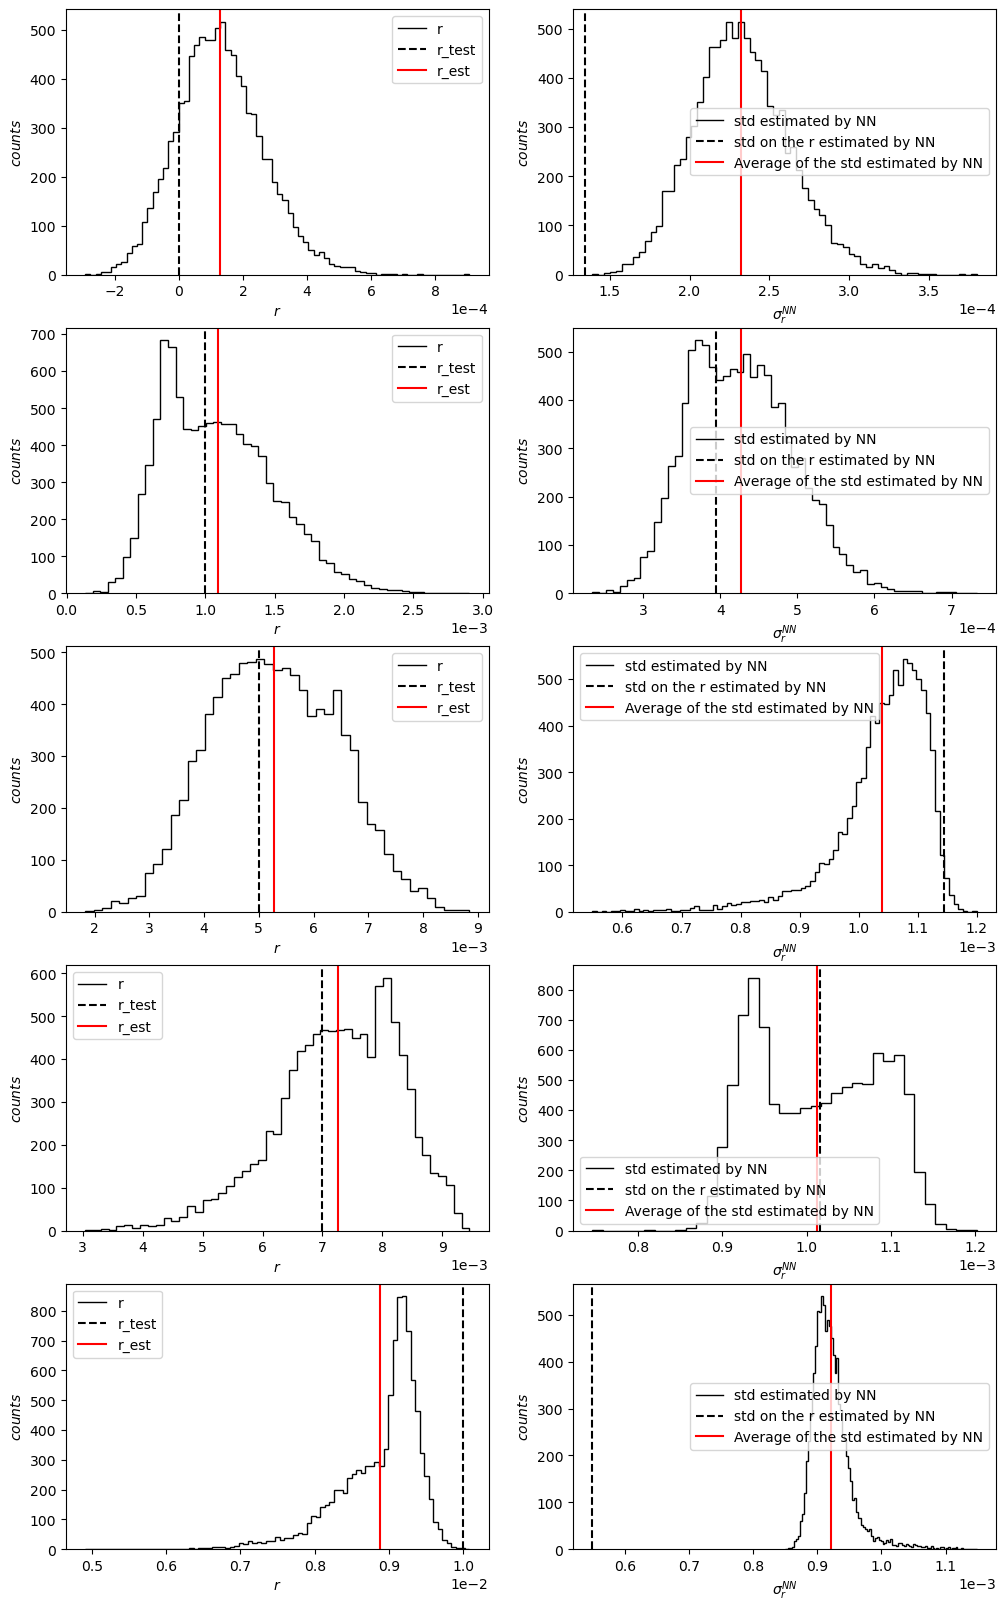

In [10]:
if loss_kind=="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (12,20))
    for i in range(len(r_pred)): #for each test_set i create an histogram of the r_pred and sigma_pred and print both 
        bin_size=100
        bin_edges= np.histogram_bin_edges(r_pred[i], bins='fd')
        print("n_of_bins:",len(bin_edges))
        counts_tau, bins_tau = np.histogram(r_pred[i], bins=bin_edges) 
        bin_edges= np.histogram_bin_edges(sigma_pred[i], bins='fd')
        counts_sigma, bins_sigma = np.histogram(sigma_pred[i], bins=bin_edges)
        plt.subplot(len(r_pred),2,2*i+1)
        plt.stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_like[i], color="black", linestyle="--", label="r_test")
        #plt.axvline(median_r[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.subplot(len(r_pred),2,2*i+2)
        plt.stairs(counts_sigma, bins_sigma, label="std estimated by NN",  color='k')
        plt.axvline(sigma_r[i], color="black", linestyle="--", label="std on the r estimated by NN")
        plt.axvline(sigma_est[i], color="red", linestyle="-", label="Average of the std estimated by NN")
        plt.legend()
        plt.ticklabel_format(style='sci',useOffset=True, axis='x', scilimits=[-1, 1])
        plt.xlabel("$\sigma_{r}^{NN}$")
        plt.ylabel("$counts$")
        plt.legend()
        #print(counts_tau, bins_tau)
        #print(np.sort(r_pred[i]))
    #plt.savefig('results_on_test.jpg') #must be in same cell or result image will be blank

In [11]:
if loss_kind!="sigma":
    r_pred=[]
    var_pred=[]
    r_est=[]
    var_r=[]
    var_est=[]
    sigma_var=[]
    mae_r=[]
    skeweness_r=[]
    skeweness_var=[]
    median_r=[]
    median_var=[]
    for i,p in enumerate(predictions):
        r_pred.append(p[:,0])
        var_pred.append(p[:,1])
        r_est.append(np.mean(r_pred[i]))
        var_r.append(np.std(r_pred[i])**2)
        var_est.append(np.mean(var_pred[i]))
        sigma_var.append(np.std(var_pred[i]))
        mae_r.append(np.sum(np.abs(r_pred[i]-r_est[i]))/len(r_pred[i]))
        skeweness_r.append(np.sum(((r_pred[i]-r_est[i])/sigma_r[i])**3)/len(r_pred[i]))
        skeweness_var.append(np.sum(((var_pred[i]-var_est[i])/sigma_var[i])**3)/len(r_pred[i]))
        median_r.append(np.median(r_pred[i]))
        median_var.append(np.median(var_pred[i]))
    r_test=np.asarray([int(x*100) for x in r_est])
    var_like=np.empty_like(r_test)
    for r in r_test:
        i=r_like.index(r)
        var_like[i]=sigma_exact[i]**2
    d["r_test"]=r_test
    d["r_est"]=r_est
    d["dr"]=np.abs(r_test-r_est)/r_est
    d["median_r-r_est"]=median_r-r_est
    d["mae_r"]=mae_r
    d["skeweness_r"]=skeweness_r
    sigma_r=var_r**{0.5}
    d["sigma_r"]=sigma_r
    sigma_est=var_est**{0.5}
    d["sigma_est"]=sigma_est
    d["dsigma"]=np.abs(sigma_r-sigma_est)/sigma_est
    d["dlike"]=np.abs(sigma_r-sigma_like)/sigma_r
    d["sigma_var"]=sigma_var
    d["median_var-var_est"]=median_var-var_est
    d["skeweness_var"]=skeweness_var

    r_data=pd.DataFrame(d)

    #define new DataFrame as original DataFrame with each row repeated 3 times
    hp_new = pd.DataFrame(np.repeat(hyperparameters.values, len(r_est), axis=0))

    #assign column names of original DataFrame to new DataFrame
    hp_new.columns = hyperparameters.columns

    out_df = pd.concat([hp_new, r_data], axis=1)

    print(out_df)
    out_df.to_csv(base_dir+'results.txt', index=False, sep=' ')

In [12]:
if loss_kind!="sigma":
    for i in range(len(r_pred)):
        print("r_est:",r_est[i],"  This is the average of the $r_{i}^{NN}$ estimated by the network on the test set.")
        print("var_r:",sigma_r[i], " This is the variance of the $r_i^{NN}$ array (variance of the prediction).", "\t The standard deviation is thus: ", np.sqrt(sigma_tau[i]))
        print("var_r_est:", sigma_r[i], "  This is the average of the $\sigma_{i}$ estimated by the network on the test set.", "\t thus taking the squareroot:",np.sqrt(sigma_est[i]), "We call it like that because $\sigma_{i}$ should be an estimate of the variance in this case → its squareroot should be an estimate of the standard deviation")
        print("\n")

In [13]:
if loss_kind!="sigma":
    fig, ax = plt.subplots(len(r_pred),2, figsize = (10,10))
    for i in range(len(r_pred)):
        counts_tau, bins_tau = np.histogram(r_pred[i])
        counts_sigma, bins_sigma = np.histogram(sigma_pred[i])
        plt.subplot(len(r_pred),2,2*i+1)
        ax[2*i+1].stairs(counts_tau, bins_tau, label="r",  color='k')
        plt.axvline(r_test[i], color="black", linestyle="--", label="r_test")
        plt.axvline(r_est[i], color="red", linestyle="-", label="r_est")
        plt.legend()
        plt.xlabel("$r$")
        plt.ylabel("$counts$")
        plt.subplot(len(r_pred),2,2*i+2)
        ax[2*i+2].stairs(counts_sigma, bins_sigma, label="std estimated by NN",  color='k')
        plt.axvline(sigma_r[i], color="black", linestyle="--", label="std on the r estimated by NN")
        plt.axvline(sigma_est[i], color="red", linestyle="-", label="Average of the std estimated by NN")
        plt.legend()
        plt.xlabel("$\sigma_{r}^{NN}$")
        plt.ylabel("$counts$")
        plt.legend()